In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression

In [2]:
location="D:\s_chernov\AnacondaProjects\SberHouse\Data\\"
tr=pd.read_csv(location+"train.csv",sep=',')
tst=pd.read_csv(location+"test.csv",sep=',')
macro=pd.read_csv(location+"sample_submission.csv",sep=',')
cheat=pd.read_csv(location+"sqprice.csv",sep=';')
prices=pd.read_csv(location+"dynamic_prices.csv",sep=';')
prices

,year_month,mean_price
0,2015_1,196000
1,2015_2,200000
2,2015_3,205000
3,2015_4,180000
4,2015_5,180000
5,2015_6,187000
6,2015_7,190000
7,2015_8,185000
8,2015_9,180000
9,2015_10,175000


In [3]:
from dateutil.parser import parse

dfDateTime=tr["timestamp"]
b=map(parse,dfDateTime)
year=map(lambda x:x.year,b)
month=map(lambda x:x.month,b)
day=map(lambda x:x.day,b)
tr['year']=year
tr['month']=month
tr['day']=day

dfDateTime=tst["timestamp"]
b=map(parse,dfDateTime)
year=map(lambda x:x.year,b)
month=map(lambda x:x.month,b)
day=map(lambda x:x.day,b)
tst['year']=year
tst['month']=month
tst['day']=day

In [4]:
tr['year_month']=map(lambda x,y:str(x)+"_"+str(y),tr.year,tr.month)
tst['year_month']=map(lambda x,y:str(x)+"_"+str(y),tst.year,tst.month)

tr=pd.merge(tr, prices, how='left', on=['year_month', 'year_month'])
tst=pd.merge(tst, prices, how='left', on=['year_month', 'year_month'])

In [5]:
#tr=pd.concat([tr, cheat], axis=1, join='outer')
#tst=pd.concat([tr, cheat], axis=1, join='outer')


tr=pd.merge(tr, cheat, how='left', on=['sub_area', 'sub_area'])
tst=pd.merge(tst, cheat, how='left', on=['sub_area', 'sub_area'])

tr.loc[:,'cheat']=tr.full_sq*tr.feb16
tst.loc[:,'cheat']=tst.full_sq*tst.feb16


In [6]:
tr=tr.drop('timestamp',axis=1)
tst=tst.drop('timestamp',axis=1)

In [58]:
#features by type
response='price_doc'

tr_type=(tr.dtypes==np.float64)|(tr.dtypes==np.int64)
dig_features=list(tr.loc[:,tr_type].columns)
dig_features.remove(response)
tr_type=(tr.dtypes==np.object)
obj_features=list(tr.loc[:,tr_type].columns)
tr2=tr.loc[tr.year==2015]


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [8]:
#___price and floor error

#print tst.loc[(tst.floor>tst.max_floor),['id','full_sq','floor','max_floor','sub_area']]

#_____price error
#print tr2.loc[(tr2.full_sq>180) &(tr2.price_doc<10000000),['id','full_sq','price_doc','sub_area']].index
tr2=tr2.drop( tr2.loc[(tr2.full_sq>180) &(tr2.price_doc<10000000)].index)

#___max_floor error
tr2=tr2.drop(tr2.loc[(tr2.floor>tr2.max_floor)].index)
correct=tst.loc[(tst.floor>tst.max_floor)].index
tst.loc[correct,'max_floor']=tst.floor[correct]+1
tr2=tr2.drop(tr2.loc[(tr2.num_room==0)].index)


In [9]:
#___square and num_room error
#print tr2.loc[(tr2.full_sq==64),['id','full_sq','num_room','price_doc','sub_area']]

tr2.loc[28867,'num_room']=1
tr2.loc[29172,'num_room']=2

tst.loc[464,'full_sq']=42
tst.loc[3500,'full_sq']=50
tst.loc[6350,'full_sq']=50
tst.loc[5383,'full_sq']=64
tst.loc[3174,'num_room']=1
tst.loc[6003,'num_room']=1
tst.loc[6181,'num_room']=2
tst.loc[7213,'num_room']=1
tst.loc[7313,'num_room']=1
tst.loc[1417,'num_room']=1
tst.loc[1429,'num_room']=1

#print tr2.loc[(tr2.full_sq/tr2.num_room<15),['id','full_sq','num_room','price_doc','sub_area']]
print tst.loc[(tst.full_sq/tst.num_room<15),['id','full_sq','num_room','sub_area']]


         id  full_sq  num_room            sub_area
2804  33278     14.8         1  Chertanovo Juzhnoe


In [10]:
#_________kitchen error

correct=tst.loc[(tst.kitch_sq/tst.full_sq>0.5)].index
tst.at[correct,'kitch_sq']=8

correct=tr2.loc[(tr.kitch_sq/tr.full_sq>0.5)].index
tr2.at[correct,'kitch_sq']=8

#print tst.loc[(tst.kitch_sq/tst.full_sq>0.5),['id','full_sq','kitch_sq','sub_area']]
#print tr2.loc[(tr2.kitch_sq/tr2.full_sq>0.5),['id','full_sq','kitch_sq','sub_area']]

#state error

tr2.at[tr2.state.isnull(),'state']=2
tst.at[tst.state.isnull(),'state']=2


In [11]:
#______last and first floor

tr2.loc[:,'first']=(tr2.floor==1).apply(int)
tr2.loc[:,'last']=(tr2.floor==tr2.max_floor).apply(int)
tst.loc[:,'first']=(tst.floor==1).apply(int)
tst.loc[:,'last']=(tst.floor==tst.max_floor).apply(int)


tr2.loc[:,'floor_low']=(tr2.floor<5).apply(int)
tst.loc[:,'floor_low']=(tst.floor<5).apply(int)

tr2.loc[:,'floor_5']=(tr2.floor==5).apply(int)
tst.loc[:,'floor_5']=(tst.floor==5).apply(int)

tr2.loc[:,'floor_9']=(tr2.floor==9).apply(int)
tst.loc[:,'floor_9']=(tst.floor==9).apply(int)

tr2.loc[:,'floor_12']=(tr2.floor==12).apply(int)
tst.loc[:,'floor_12']=(tst.floor==12).apply(int)

tr2.loc[:,'floor_13_18']=((tr2.max_floor>12) & (tr2.max_floor<=18)).apply(int)
tst.loc[:,'floor_13_18']=((tst.max_floor>12) & (tst.max_floor<=18)).apply(int)

tr2.loc[:,'floor_high']=(tr2.floor>18).apply(int)
tst.loc[:,'floor_high']=(tst.floor>15).apply(int)


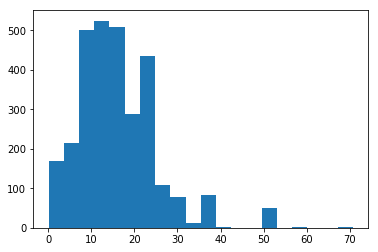

In [12]:
tr2.loc[:,'kremlin_near']=(tr2.kremlin_km<3).apply(int)
tst.loc[:,'kremlin_near']=(tst.kremlin_km<3).apply(int)

tr2.loc[:,'kremlin_1_5']=((tr2.kremlin_km>=1) & (tr2.kremlin_km<=5)).apply(int)
tst.loc[:,'kremlin_1_5']=((tst.kremlin_km>=1) & (tst.kremlin_km<=5)).apply(int)

tr2.loc[:,'kremlin_5_10']=((tr2.kremlin_km>5) & (tr2.kremlin_km<10)).apply(int)
tst.loc[:,'kremlin_5_10']=((tst.kremlin_km>5) & (tst.kremlin_km<10)).apply(int)


plt.hist(tr2.kremlin_km,20)
plt.show()

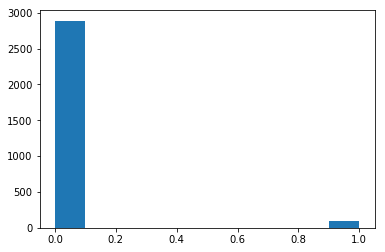

In [13]:
plt.hist(tr2.floor_high)
plt.show()

In [14]:
#ownership

tr2.loc[:,'own']=(tr2.product_type=='OwnerOccupier').apply(int)
tst.loc[:,'own']=(tst.product_type=='OwnerOccupier').apply(int)

#poselenie
#area_mo='Poselenie|Silino|Troickij okrug|Matushkino|Savelki|Severnoe|Vnukovo'
area_mo='Poselenie'


tr2.loc[:,'poselok']=tr2.sub_area.str.contains(area_mo).apply(int)
tst.loc[:,'poselok']=tst.sub_area.str.contains(area_mo).apply(int)

#radiation

tr2.loc[:,'radiate']=(tr2.radiation_raion=='yes').apply(int)
tst.loc[:,'radiate']=(tst.radiation_raion=='yes').apply(int)



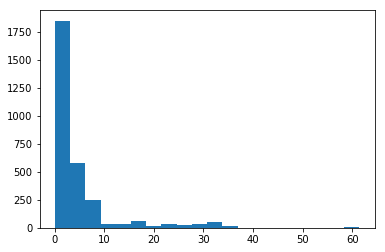

In [16]:
plt.hist((tr2.metro_min_avto),20)
plt.show()

#___metro features
tr2.loc[:,'metro_near']=(tr2.metro_min_avto<=3.4).apply(int)
tst.loc[:,'metro_near']=(tst.metro_min_avto<=3.4).apply(int)
tr2.loc[:,'metro_far']=(tr2.metro_min_avto>=20).apply(int)
tst.loc[:,'metro_far']=(tst.metro_min_avto>=20).apply(int)


In [17]:
from sklearn.model_selection import train_test_split


features=['num_room','full_sq','kitch_sq','floor','first','last',
          'floor_low','floor_5','floor_9','floor_12','floor_13_18','floor_high',
          'state','kremlin_near','kremlin_1_5','kremlin_5_10','mean_price',
          'own','metro_near','metro_far','poselok','radiate','indust_part']



features_mos=['num_room','full_sq','kitch_sq','floor','first','last',
          'floor_low','floor_5','floor_9','floor_12','floor_13_18','floor_high',
          'state','sadovoe_km','kremlin_1_5','indust_part','feb16','cheat',
          'own','metro_min_avto','mean_price','material']



features_pos=['num_room','full_sq','first','last',
          'floor_12','mkad_km','metro_min_avto','indust_part','mean_price']

np.random.seed(123)


tr_pos=tr2[tr2.poselok==1]
tr_mos=tr2[tr2.poselok==0]
tst_pos=tst[tst.poselok==1]
tst_mos=tst[tst.poselok==0]

X_train, X_test, y_train, y_test = train_test_split(tr2.loc[:,features], tr2.price_doc, test_size=0.33, random_state=42)
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(tr_pos.loc[:,features_pos], tr_pos.price_doc, test_size=0.33, random_state=42)
X_train_mos, X_test_mos, y_train_mos, y_test_mos = train_test_split(tr_mos.loc[:,features_mos], tr_mos.price_doc, test_size=0.33, random_state=42)


In [34]:
#----all linear
#fit1 = LinearRegression()

fit1 = Lasso(alpha=0.7,fit_intercept=True,positive=False)
fit1 = fit1.fit(X_train, y_train)
print(zip(features,fit1.coef_))
#pred = fit2.predict(X_test)
fit1.score(X_test,y_test)

[('num_room', -178597.30235694791), ('full_sq', 162387.07020639555), ('kitch_sq', 58178.799312658062), ('floor', 25126.667701352151), ('first', -1185213.8027422931), ('last', -499762.51904943644), ('floor_low', -302531.83171598177), ('floor_5', -286744.36851588491), ('floor_9', -179408.51678782917), ('floor_12', 622722.0562141767), ('floor_13_18', -189520.23476776091), ('floor_high', 717690.82869930263), ('state', 830141.8295003043), ('kremlin_near', -1052479.5203146259), ('kremlin_1_5', 6064597.160015828), ('kremlin_5_10', 1836689.9572893505), ('mean_price', 7.0506412580365492), ('own', 687649.51917438244), ('metro_near', 871048.81335859653), ('metro_far', -1090538.2785541762), ('poselok', -1832527.6515936814), ('radiate', 167366.56776669089), ('indust_part', -3873155.5654301443)]


0.59752681247283645

In [50]:
#poselok linear
#fit2= LinearRegression()
fit2 = Lasso(alpha=0.1,fit_intercept=True,positive=False)
fit2= fit2.fit(X_train_pos, np.sqrt(y_train_pos))
print(zip(features_pos,fit2.coef_))
pred = fit2.predict(X_test_pos)
pred=pred**2
#print fit2.score(X_test_pos,y_test_pos)

pred[pred<900000]=900000

print r2_score (y_test_pos,pred)
print len(pred),min(pred),max(pred)
print len(y_test_pos),min(y_test_pos),max(y_test_pos)



[('num_room', 94.067568024197982), ('full_sq', 10.937465927038989), ('first', -33.071735361977943), ('last', -2.7998383268681177), ('floor_12', 11.30012473911937), ('mkad_km', -8.9489819686784013), ('metro_min_avto', -17.804355811810069), ('indust_part', -1583.6339636971688), ('mean_price', 0.0035903548747688802)]
0.825067037321
260 900000.0 15123923.0483
260 990000 15043290


In [49]:
#moscow linear
#fit2= LinearRegression()
fit2 = Lasso(alpha=0.1,fit_intercept=True,positive=False)

fit2= fit2.fit(X_train_mos, np.sqrt(y_train_mos))
print(zip(features_mos,fit2.coef_))
pred = fit2.predict(X_test_mos)
pred=pred**2

#print fit2.score(X_test_mos,y_test_mos)
pred[pred<950000]=950000

print '________________'
print r2_score (y_test_mos,pred)
print len(pred),min(pred),max(pred)
print len(y_test_mos),min(y_test_mos),max(y_test_mos)



[('num_room', 19.663973047211446), ('full_sq', 22.548575409826544), ('kitch_sq', 12.208066041381548), ('floor', 12.823816079345326), ('first', -206.4857100478888), ('last', -110.28577966879382), ('floor_low', 39.821439244656382), ('floor_5', -80.896777140726655), ('floor_9', 28.500723520133207), ('floor_12', 91.142612500391309), ('floor_13_18', 5.3400578516353949), ('floor_high', 194.19969479832355), ('state', 95.438038861793316), ('sadovoe_km', -33.256348920672266), ('kremlin_1_5', 363.8117358323766), ('indust_part', -498.39713713095176), ('feb16', -0.0023975007786131474), ('cheat', 1.149729876320179e-05), ('own', 39.098683991286599), ('metro_min_avto', 7.4095387240120543), ('mean_price', 0.00086440035556453331), ('material', 1.3055945627647578)]
________________
0.618578497963
724 2452464.19154 54998329.9785
724 976000 70000000


np.random.seed(123)
tr_mos=tr2[tr2.poselok==0]
tst_mos=tst[tst.poselok==0]

tr_type=(tr_mos.dtypes==np.float64)|(tr_mos.dtypes==np.int64)
dig_features_mos=list(tr_mos.loc[:,tr_type].columns)
X_train_mos, X_test_mos, y_train_mos, y_test_mos = train_test_split(tr_mos.loc[:,dig_features_mos], tr_mos.price_doc, test_size=0.33, random_state=42)

X_train_mos[X_train_mos.isnull()]=99999
X_test_mos[X_test_mos.isnull()]=99999


np.random.seed(123)
fit_rf = RandomForestClassifier(n_jobs=2,n_estimators=150)
fit_rf= fit_rf.fit(X_train_mos, y_train_mos)
pred = fit_rf.predict(X_test_mos)

#pred[pred<950000]=950000

print '________________'
print r2_score (y_test_mos,pred)
print len(pred),min(pred),max(pred)
print len(y_test_mos),min(y_test_mos),max(y_test_mos)


In [51]:
#3 linear model for pos 
#fit = LinearRegression()
fit = Lasso(alpha=0.1,fit_intercept=True,positive=False)
X=tr2.loc[tr2.poselok==1,features_pos]
Y=tr2.loc[tr2.poselok==1,'price_doc']
fit = fit.fit(X, np.sqrt(Y))

pred_pos = fit.predict(tst.loc[tst.poselok==1,features_pos])
pred_pos=pred_pos**2
pred_pos[pred_pos<900000]=900000

print len(pred_pos),min(pred_pos),max(pred_pos)
print len(Y),min(Y),max(Y)


1575 1272402.00797 15499510.7491
785 990000 15043290


In [52]:
#3 linear model for pos and mos
#fit = LinearRegression()
fit = Lasso(alpha=0.1,fit_intercept=True,positive=False)

X=tr2.loc[tr2.poselok==0,features_mos]
Y=tr2.loc[tr2.poselok==0,'price_doc']
fit = fit.fit(X, np.sqrt(Y))

pred_mos = fit.predict(tst.loc[tst.poselok==0,features_mos])
pred_mos=pred_mos**2
pred_mos[pred_mos<900000]=900000
print len(pred_mos),min(pred_mos),max(pred_mos)



6087 2231984.19552 154420033.192


In [53]:
res1=pd.DataFrame({'id':tst.loc[tst.poselok==1,'id'],'price_doc':(pred_pos)})
#print res1.describe()

res2=pd.DataFrame({'id':tst.loc[tst.poselok==0,'id'],'price_doc':(pred_mos)})
#print res2.describe()
res=pd.concat([res1,res2])
del res1,res2

In [54]:
#pd.DataFrame({'id':tst.id,'price_doc':(pred)}).to_csv(location+'submission.csv',sep=',',index=False)
res.to_csv(location+'submission2.csv',sep=',',index=False)


In [55]:
np.random.seed(123)


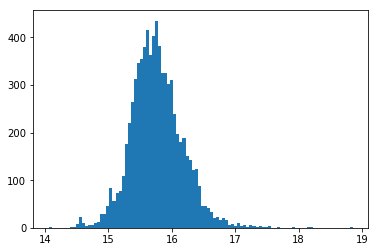

In [57]:
plt.hist(np.log(res.price_doc),100)
plt.show()